# Final Project - Crime Rate in San Diego Around The Holidays

#### Vincent Salinas A14168881 <br>
Data Cleaning/Preprocessing, Data Analysis

#### Joonhan Song A91061925 <br>
Data Cleaning/Preprocessing, Data Analysis

#### Shonak Shah A13497236 <br>
Data Visualization

#### Kevin Sayed A14119291 <br>
Data Visualization

#### John Abboud A13194739 <br>
Data Cleaning/Preprocessing, Comments/Descriptions/Write-Up

#### Atalie Liu A13617263 <br>
Comments/Descriptions/Write-Up

## Introduction & Background
Crime is an issue that will never be stopped, no matter the time of the year. In San Diego, tons of events are held year round, especially during the holidays. Due to the festivities around Halloween, Thanksgiving, Christmas, and New Years, more people are inebriated and we hypothesized that they will be more likely to cause crimes involving alcohol or drugs. We also hypothesized that people were more likely to commit theft, robberies, and burglaries due to gift giving, as well as huge sales in the holiday season(in particular, Black Friday). 

We decided to take a closer look at particular time frames within the holiday season, the days of the holidays: Halloween (October 31 2017), Thanksgiving (November 23 2017), Christmas(December 25 2017), and New Year’s (January 1 2018). We also took random days throughout the year of which we did not suspect have any major significance in San Diego, and checked the crimes for those dates. As different studies and news article have shown, there are different conclusive evidence of whether or not crime rate goes up or down around the holidays (http://www.oxygen.com/homicide-for-the-holidays/blogs/its-the-most-dangerous-time-of-the-year-why-do-crimes-increase) and (http://www.sherrytowers.com/crime_and_holidays.pdf). 

## Research Question
Since San Diego is one of the safer big cities in the country, we wanted to see which way crime rate goes around the holidays. Are there any major differences between crime rate on these four holidays as compared to crime rate on "usual" or normal days of the year? 

In order to answer this question, we looked at crimes in categories that we created to broaden the numerous crimes that exist. We checked these specific crimes on each of the four holidays as well as particular time frames near these holidays, and also compared each holiday to one another. 

## Dataset

http://www.sandag.org/index.asp?classid=14&subclassid=21&projectid=446&fuseaction=projects.detail


Our dataset consists of information about crimes in San Diego County with the most recent 180 days of data. The link updates itself every week for the most recent information, so we have one file in our project repository corresponding to the correct days that we used for our data. The dataset consists of the arresting agency, crime committed, time of report, and address, zipcode, and community the crime took place.

We were able to gather this link with reliable information from SANDAG, which serves as a forum for government regional decision making. The data should be as accurate as listed in the official police system, since all information is taken directly from the police departments of San Diego County. We believe that with this information, we should be able to see which kind of crimes are more prevalent around holidaysas well as where they occur. 

We hypothesize that this information can allow us to decide if there needs to be any more or less police officers dispatched at this certain time of the year. 

## Data Cleaning / Pre-processing
For data within the dataset associated with crime, we pre-process it, using a separate open source library, in order to better clean the information to be analyzed. The first thing to notice is how "messy" each description is under the charge column, so we standardize the data to make useful analyzes out of it. Since we only want our data to revolve around the holidays, or within the relevant time frames of interest, we make sure to only include those dates. We also noticed that the dataset that we plan to use for our analysis contain location information, which can be translated into geocoded addresses. Based off this observation, we hypothesized that it would be useful to identify more concentrated crime areas within San Diego. In other words, we wanted to determine the different crimes associated with a given latitude or longitude. 

In [62]:
# Imports

%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import string
import pylab
import requests
import numpy as np
import pandas as pd

import patsy
import requests
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

from dateutil.parser import parse
from collections import Counter

In [63]:
# Load raw crime data into panda dataframe
crime_data_raw = pd.read_csv('Crime_Data.csv')  

# Create a copy of our raw crime data
crime_data = crime_data_raw.copy()

# Simplify column names
crime_data.columns = ['agency','crime','time','address','zipcode','community']

# Drop null values found in the crime column
crime_data.dropna(axis=0, subset=['crime'], inplace=True)

# Survey our data
crime_data.head(5)

,agency,crime,time,address,zipcode,community
0,SAN DIEGO,GRAND THEFT FROM PERSON,1/3/2018 16:30,7800 BLOCK STALMER STREET,92111.0,SAN DIEGO
1,HARBOR POLICE,SELL LIQUOR TO MINOR (M),9/23/2017 18:28,3200 BLOCK NORTH HARBOR DRIVE,92101.0,SAN DIEGO
2,HARBOR POLICE,"DRUNK IN PUBLIC: ALCOHOL, DRUGS, COMBO OR TOLU...",10/6/2017 8:48,600 BLOCK CONVENTION WAY,92101.0,SAN DIEGO
3,HARBOR POLICE,"DRUNK IN PUBLIC: ALCOHOL, DRUGS, COMBO OR TOLU...",10/11/2017 19:45,3600 BLOCK NORTH HARBOR DRIVE,92101.0,SAN DIEGO
4,HARBOR POLICE,POSS NARCOTIC CONTROLLED SUBS (M),10/21/2017 23:36,100 W BLOCK HARBOR DRIVE,92101.0,SAN DIEGO


In [64]:
# How many unique crimes in the dataset?
crime_data['crime'].nunique()

727

Having 727 unique crimes in the dataset, we needed to narrow down the number of unique crimes in order to properly track crime trends. To do this, we wrote a substring checking function that matched a crime into 1 of 19 crime categories, such as 'Theft', 'Assult', and 'Robbery'. Crimes that did not fit these prominent categories were placed into an 'Other Offense' category. 

In [65]:
# Create each unique crime category and their corresponding vocabulary
theft = ['shoplifting','theft','credit','identity','identification','defraud','defrauding']
battery = ['battery']
property_crimes = ['vandalize','vandalism']
narcotics = ['cannabis','drug','drugs','narcotic','marijuana','cocaine','sub','subs','substance']
assault = ['assault']
other_offense = ['park','impersonate']
alcohol = ['dui','alcohol','drunk']
burglary = ['burglary']
motor_vehicle_theft = ['vehicle','auto']
robbery = ['robbery','rob']
possession = ['poss','paraphernalia']
weapons_violation = ['knuckles','knife','blade','firearm','carry']
public_peace_violation = ['disorderly']
offense_involving_children = ['minor','molest']
prostitution = ['prostitution']
interference_with_public_officer = ['officer']
sex_offense = ['sex','sexual']
homicide = ['homicide','kill','murder']
arson = ['arson']

# Remove symbols from crime string inside function
table = str.maketrans("/,:-",4*" ")

# Takes a string of crime name and returns its respective crime category 
def standardize_crime(string):
    s = string.lower()
    s = s.translate(table)

# Checks if vocabulary in crime category matches that in inputed crime and returns new crime category
    for i in theft:
        if i in s:
            return "THEFT"
    for i in battery:
        if i in s:
            return "BATTERY"
    for i in property_crimes:
        if i in s:
            return "PROPERTY CRIME"
    for i in narcotics:
        if i in s:
            return "NARCOTICS"    
    for i in assault:
        if i in s:
            return "ASSULT"
    for i in other_offense:
        if i in s:
            return "OTHER OFFENSE"
    for i in alcohol:
        if i in s:
            return "ALCOHOL"
    for i in burglary:
        if i in s:
            return "BURGLARY"
    for i in motor_vehicle_theft:
        if i in s:
            return "MOTOR VEHICLE THEFT"
    for i in robbery:
        if i in s:
            return "ROBBERY"
    for i in possession:
        if i in s:
            return "POSSESSION"
    for i in weapons_violation:
        if i in s:
            return "WEAPONS VIOLATION"
    for i in public_peace_violation:
        if i in s:
            return "PUBLIC PEACE VIOLATION"
    for i in offense_involving_children:
        if i in s:
            return "OFFENSE INVOLVING CHILDREN"
    for i in prostitution:
        if i in s:
            return "PROSTITUTION"
    for i in interference_with_public_officer:
        if i in s:
            return "INTERFERENCE WITH PUBLIC OFFICER"
    for i in sex_offense:
        if i in s:
            return "SEX OFFENSE"
    for i in homicide:
        if i in s:
            return "HOMICIDE"
    for i in arson:
        if i in s:
            return "ARSON"

# Apply standardize_crime to each crime in crime_data and return updated crime column
crime_data['crime'] = crime_data['crime'].apply(standardize_crime)

# A quick look at our processed data
crime_data.head(5)

,agency,crime,time,address,zipcode,community
0,SAN DIEGO,THEFT,1/3/2018 16:30,7800 BLOCK STALMER STREET,92111.0,SAN DIEGO
1,HARBOR POLICE,OFFENSE INVOLVING CHILDREN,9/23/2017 18:28,3200 BLOCK NORTH HARBOR DRIVE,92101.0,SAN DIEGO
2,HARBOR POLICE,NARCOTICS,10/6/2017 8:48,600 BLOCK CONVENTION WAY,92101.0,SAN DIEGO
3,HARBOR POLICE,NARCOTICS,10/11/2017 19:45,3600 BLOCK NORTH HARBOR DRIVE,92101.0,SAN DIEGO
4,HARBOR POLICE,NARCOTICS,10/21/2017 23:36,100 W BLOCK HARBOR DRIVE,92101.0,SAN DIEGO


# Data Visualization

When originally looking at the data, we were conflicted with the best possible method for creating an effective visualization process for our crime data. We decided that the best course of action was to look at the geolocation of individual crime points and outlay crimes that occured on holidays on top of said plot. This form of visualization allowed us to take a deeper look at our data points and possibly find some location specific analysis for our conclusion. To do so, we looked to run the addresses of the crimes through the google geocoder which returns a pair of latitude and longitude points for each address and plot them accordingly.

In [ ]:
# Since our crime data had now been processed, we needed to 
# create another dataframe specifically for geomapping using Google Maps
crime_data.to_csv('Crime_Data_Pr.csv')

# encode dataset using 'ISO-8859-1' in order to use Data Visualization with Google
original = pd.read_csv('Crime_Data_Pr.csv', encoding = 'ISO-8859-1')
original = original.drop('Unnamed: 0', axis=1)

#Import google map for geocoding
import googlemaps

# Key taken out so no geocoding can occur anymore
gmaps_key = googlemaps.Client(key = '')

First, we had to combine columns in our dataset to create the most geocodable address. We did this by appending zip code, address, and the community of each crime into a seperate column: “geocode_address”. 

In [ ]:
#look through community and zipcode and make sure there are no nan values. create the geocode_address accordingly.
geocode_address = []
for i in range(len(original)):
    if (np.isnan(original.zipcode[i]) ==True) & (type(original.community[i]) != str): #if both zip and community are nan, geocode_address = address
        geocode_address.append(original.address[i])
    elif np.isnan(original.zipcode[i]) == True: #if only zip is nan, geocode_address = address + community
        geocode_address.append(''+ original.address[i] + ' ' + original.community[i])
    elif type(original.community[i]) != str: #if only community is nan, geocode_address = zip + address
        geocode_address.append(''+ original.address[i] + ' ' + str(int(original.zipcode[i])).strip())
    else:
        geocode_address.append(''+ original.address[i] + ' ' + str(int(original.zipcode[i])).strip() + ' ' + original.community[i].strip()) #else geocode_address = zip + address + community
original['geocode_address'] = geocode_address

We then wrote a function that would take a date and a file_name and write the latitude and longitude of all the crimes that occured in that date to a csv file.

In [ ]:
def geocode(date,file_name):
    set_dates = date_finder(date) #add crimes that occurred on "date" to a list "set_dates"

    #loop through all  rows in set_dates and use the google geocode api to find the lat/long
    for x in set_dates: 
        inputAddress = x[6]
        result = gmaps_key.geocode(inputAddress)
        try:
            location = result[0]['geometry']['location']
            lat = location['lat']
            long = location['lng']
            lat_lst.append(lat)
            long_lst.append(long)
        except:
            lat_lst.append(None)
            long_lst.append(None)   
    #load the lat/long to a dataframe and check to make sure they fall within the correct boundary.        
    lat_long_df = pd.DataFrame({'latitude' : lat_lst,'longitude' : long_lst})
    lat_long_df = lat_long_df[(lat_long_df['latitude'] > 31.5) &
                    (lat_long_df['latitude'] < 34.5) &
                    (lat_long_df['longitude'] > -118) &
                    (lat_long_df['longitude'] < -116)]
    lat_long_df.to_csv(file_name, index = False) #write dataframe to a csv

This next cell was ran multiple times in order to create all the necessary csv files. Here is an example of what creating one csv would look like

In [ ]:
geocode('12/25/2017','Christmas.csv')

As the data has already been geocoded, we will simply import the necessary csv files and use them. We created one dataframe that was the aggregate of all the crime data we geocoded. There were a total of 5740 individual points used for the following data Visualization.

In [4]:
#load the csv files
df = pd.read_csv('None_Holidays.csv')
df_Halloween = pd.read_csv('Halloween.csv')
df_Year = pd.read_csv('New_years.csv')
df_Thanks = pd.read_csv('Thanksgiving.csv')
df_Christmas = pd.read_csv('Christmas.csv')

#create a dataframe that is the aggregate of all other csv files
df = df.append(df_Halloween)
df = df.append(df_Year)
df = df.append(df_Thanks)
df = df.append(df_Christmas)

#ensure boundaries of the lat/long
df = df[(df['latitude'] > 31.5) &
                    (df['latitude'] < 33.5) &
                    (df['longitude'] > -118) &
                    (df['longitude'] < -116)]

Since latitude and longitude represent the x/y coordinate pla, we can simply plot out all our points and see a rough sketch of the San Diego area. Keep in mind that the community was not limited to just San Diego and reach as far as Oceanside. We decided to look at multiple permutations of our data to get better understanding of how it worked and what it looked like.

We first ploted the lat/long of our total data to see a sketch of the San Diego area. We then plotted the individual points for each holiday and color coded them. However, this first permutation was too messy and there was not a noticable pattern. It did, however, provide a good understanding of how the crime mapped geographically. 

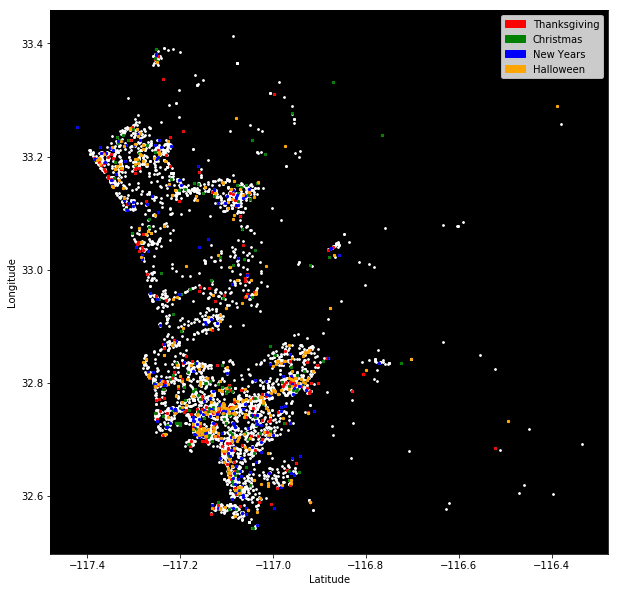

In [5]:
#create plot and set proper points
plt.figure(figsize=(10, 10))
plt.scatter(df['longitude'], df['latitude'], c='white', s=3)
plt.scatter(df_Thanks['longitude'], df_Thanks['latitude'], c='red', s=5)
plt.scatter(df_Christmas['longitude'], df_Christmas['latitude'], c='green', s=5)
plt.scatter(df_Year['longitude'], df_Year['latitude'], c='blue', s=5)
plt.scatter(df_Halloween['longitude'], df_Halloween['latitude'], c='orange', s=5)

#set plot axis
axes = plt.gca()
axes.set_xlabel('Latitude')
axes.set_ylabel('Longitude')
axes.set_facecolor('xkcd:black')

#set the proper patch(key) for the plot
thanks_patch = mpatches.Patch(color='red', label='Thanksgiving')
Christmas_patch = mpatches.Patch(color='green', label='Christmas')
Year_patch = mpatches.Patch(color='blue', label='New Years')
Halloween_patch = mpatches.Patch(color='orange', label='Halloween')
plt.legend(handles=[thanks_patch, Christmas_patch, Year_patch, Halloween_patch ])

We then looked at each holiday mapped individually. For Thanksgiving, the geolocation mapped pretty similarly to the total crime count. The cluster of crimes stayed consistent with the cluster of total crimes. However, it seems as if though there is a heavy concentration of crime in the coastal region

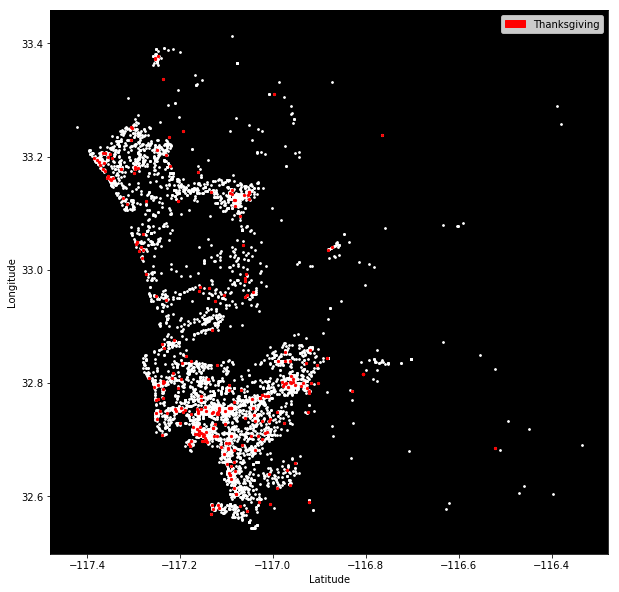

In [6]:
#create plot and set proper points
plt.figure(figsize=(10, 10))
plt.scatter(df['longitude'], df['latitude'], c='white', s=3)
plt.scatter(df_Thanks['longitude'], df_Thanks['latitude'], c='red', s=5)

#set plot axis
axes = plt.gca()
axes.set_xlabel('Latitude')
axes.set_ylabel('Longitude')
axes.set_facecolor('xkcd:black')

#set the proper patch(key) for the plot
plt.legend(handles=[thanks_patch])

We repeated the same proccess Christmas. Similar to Thanksgiving, Christmas also stayed consistent with the clusters of the total crimes. As we will see in the data analysis, however, christmas has significantly less crime then other days and that can even be seen by just looking at the plotted data. Christmas crimes, unlike thanksgiving, also stayed away from the coastal regions.

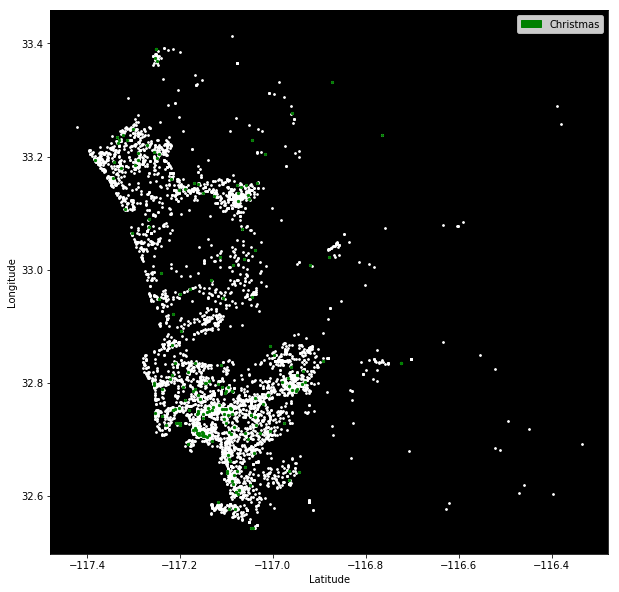

In [7]:
#create plot and set proper points
plt.figure(figsize=(10, 10))
plt.scatter(df['longitude'], df['latitude'], c='white', s=3)
plt.scatter(df_Christmas['longitude'], df_Christmas['latitude'], c='green', s=5)

#set plot axis
axes = plt.gca()
axes.set_xlabel('Latitude')
axes.set_ylabel('Longitude')
axes.set_facecolor('xkcd:black')

#set the proper patch(key) for the plot
plt.legend(handles=[Christmas_patch])

We again repeated the same process for New Years and found the data to be visually consistent with our total crime count. The New Years data, unlike the other two, seemed much more spread out across all possible geolocation with fewers large clusters we saw in the previous holidays

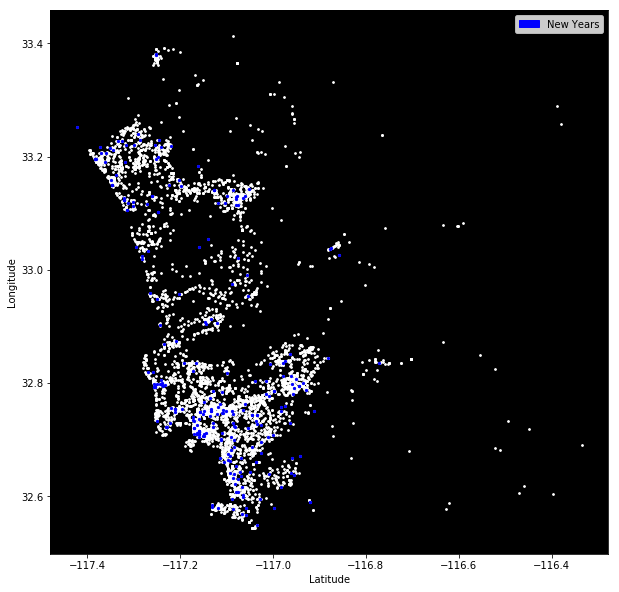

In [8]:
#create plot and set proper points
plt.figure(figsize=(10, 10))
plt.scatter(df['longitude'], df['latitude'], c='white', s=3)
plt.scatter(df_Year['longitude'], df_Year['latitude'], c='blue', s=5)

#set plot axis
axes = plt.gca()
axes.set_xlabel('Latitude')
axes.set_ylabel('Longitude')
axes.set_facecolor('xkcd:black')

#set the proper patch(key) for the plot
plt.legend(handles=[Year_patch])

We also ran this visiual comparison on the Halloween data. Once again, similar results which mimick the total crimes. however, Halloween did seem to have a heavy concentration of crime in land rather than coastal. The crimes also seemed to be much more clustered than the previously observed holidays.

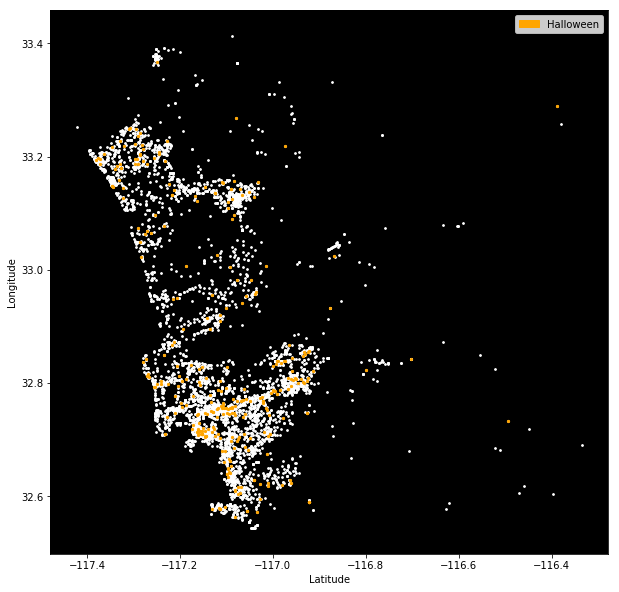

In [9]:
#create plot and set proper points
plt.figure(figsize=(10, 10))
plt.scatter(df['longitude'], df['latitude'], c='white', s=3)
plt.scatter(df_Halloween['longitude'], df_Halloween['latitude'], c='orange', s=5)

#set plot axis
axes = plt.gca()
axes.set_xlabel('Latitude')
axes.set_ylabel('Longitude')
axes.set_facecolor('xkcd:black')

#set the proper patch(key) for the plot
plt.legend(handles=[Halloween_patch])

Theft might be low since, as stated earlier, most people are spending times with their family or friends in parties. Burglary might be down since many people are at home giving out candy to children and there are usually lots of people walking the streets on Halloween night. The day after, people may be getting charges for the mistakes that they made on Halloween since there are more alcohol charges. As with New Years, people may be wanting to buy more drugs as they may have used it all on Halloween night, relaying to the increase in narcotics.

Lastly, we plotted both the Halloween and the Christmas data on the same graph to see if we could take a closer look at the geodifferences between the two. The differences noticed when comparing them individually still stayed true. Halloween crimes tended to be heavily clustered in land while the christmas crimes were focused more coastal. NOTE: since the christmas data is plotted after the Halloween data, they will be plotted over them.

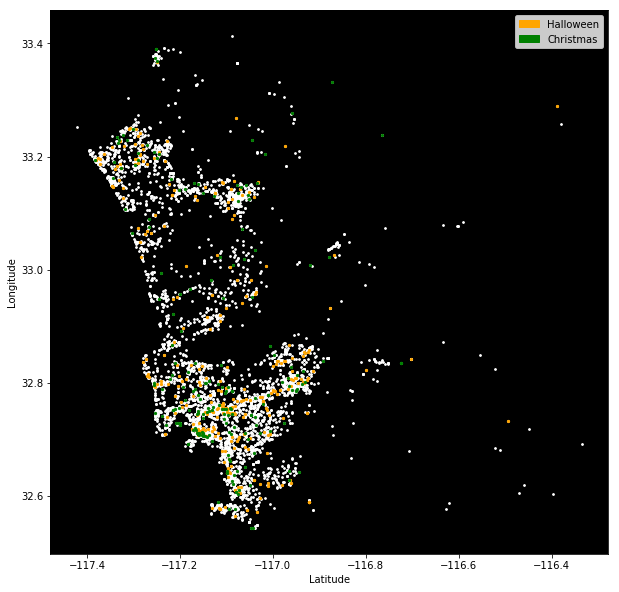

In [8]:
#create plot and set proper points
plt.figure(figsize=(10, 10))
plt.scatter(df['longitude'], df['latitude'], c='white', s=3)
plt.scatter(df_Halloween['longitude'], df_Halloween['latitude'], c='orange', s=5)
plt.scatter(df_Christmas['longitude'], df_Christmas['latitude'], c='green', s=5)

#set plot axis
axes = plt.gca()
axes.set_xlabel('Latitude')
axes.set_ylabel('Longitude')
axes.set_facecolor('xkcd:black')

#set the proper patch(key) for the plot
plt.legend(handles=[Halloween_patch, Christmas_patch])

Our data visualization provided a solid basis which helped us make the net decision for our analysis. We originally had thought that geolocation could play a factor if we were to find significant results. However, we did not find any convincing evidence based of the above visualizations which proved such case. Thus we move to analysis of our data based of the type of crime committed. 

# Data Analysis

For our data analysis we took a closer look at crimes during time frames of holidays (Halloween, Thanksgiving, Christmas, New Years) and found the trends for that day, We also looked at specific crimes that we put into different categories in our data cleaning section, and tried to look at the trends before the holiday and after the holiday. We stated our hypotheses as to why we might think that these particular trends occurred and finally we compared all holidays together in our final bar graph.

In [67]:
# Numerous helper functions defined below to allow us to translate and gather information.

count = 0
date = []
for x in original['time']:
    if(x.find('2018') == -1):
        date.append(x[:x.find('2017')+ 4])
    else:
        date.append(x[:x.find('2018')+ 4])
date
original['date'] = date
#stuff = stuff['agency', 'Charge_Description_Orig' , 'activityDate', 'date', 'BLOCK_ADDRESS', 'ZipCode', 'community']

#loop through stuff to find all crimes that happened on christmas and add them to a list.
def date_finder(date):
    lst = []
    for i, row in enumerate(original.values):
        if(row[6].find(date) != -1):
             lst.append(row[1])
    return lst

#This grabs the days of crimes
def date_crime_counter(date):
    count = 0
    for i, row in enumerate(original.values):
        if(row[6].find(date) != -1):
            count = count + 1
    return count
            
#same idea as above loop but used to check total crimes on any day. you can play around with the specifc day by changing the value
# in "('12/30/2017')"
for i, row in enumerate(original.values):
    if(row[6].find('12/25/2017') != -1):
        count = count + 1
#print(count)

In [68]:
def find_crime_date (date, c_l, d_l):
    crime_count = 0
    date_finder(date)
    d_l.append(date)
    crime_count = date_crime_counter(date)
    c_l.append(crime_count)
    return crime_count

In [69]:
def t_test(usual,during):
    t_val, p_val = stats.ttest_ind(usual,during)
    if p_val < 0.05:
        print('T-Test accomplished, there is a significant difference between usual crime and over holiday!')
    else:
        print('There is NOT a significant difference!')
    return(t_val, p_val)

We create another dataframe with numbers of crimes for the timeframe before Christmas and after New Years. We then create a line graph and plot the dates along with the crimes. We can see that crime peaks on the 23rd of December, two days before Christmas, then goes down at a steady decline until Christmas, where for the following few days, crime increases at a steady incline again. On New Years Eve, crime decreases quite a bit but quickly goes back up on New Years. 

We hypothesize that crime rate may be high with the days preceding Christmas due to more theft charges, since we think that people may be trying to get last minute gifts for family and friends. Meanwhile, most stores may be closed on Christmas and many people may be spending time with their loved ones on this holiday. We also hypothesize that New Years may have higher counts of crime due to more alcohol or drug related crimes. 

### Usual Crime versus Crimes around Holiday season

#### Christmas and New Years

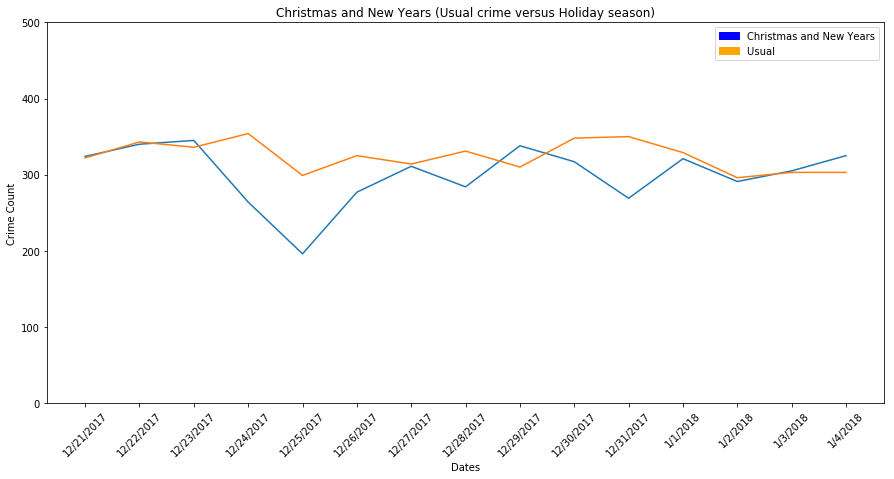

In [70]:
import matplotlib.patches as mpatches

ch_ny_result = pd.DataFrame(columns=['Date', 'Crime Number'])
crime_list = []
date_list = []
crime_count = 0

#Christmas and New Year
find_crime_date ('12/21/2017', crime_list, date_list)
find_crime_date ('12/22/2017', crime_list, date_list)
find_crime_date ('12/23/2017', crime_list, date_list)
find_crime_date ('12/24/2017', crime_list, date_list)
find_crime_date ('12/25/2017', crime_list, date_list)
find_crime_date ('12/26/2017', crime_list, date_list)
find_crime_date ('12/27/2017', crime_list, date_list)
find_crime_date ('12/28/2017', crime_list, date_list)
find_crime_date ('12/29/2017', crime_list, date_list)
find_crime_date ('12/30/2017', crime_list, date_list)
find_crime_date ('12/31/2017', crime_list, date_list)
find_crime_date ('1/1/2018', crime_list, date_list)
find_crime_date ('1/2/2018', crime_list, date_list)
find_crime_date ('1/3/2018', crime_list, date_list)
find_crime_date ('1/4/2018', crime_list, date_list)


se_c = pd.Series(crime_list)
se_d = pd.Series(date_list)
ch_ny_result['Crime Number'] = se_c
ch_ny_result['Date'] = se_d

weeks_b4_ch_ny = pd.DataFrame(columns=['Date', 'Crime Number'])
crime_list = []
date_list = []
crime_count = 0
# usual crime
find_crime_date ('12/6/2017', crime_list, date_list)
find_crime_date ('12/7/2017', crime_list, date_list)
find_crime_date ('12/8/2017', crime_list, date_list)
find_crime_date ('12/9/2017', crime_list, date_list)
find_crime_date ('12/10/2017', crime_list, date_list)
find_crime_date ('12/11/2017', crime_list, date_list)
find_crime_date ('12/12/2017', crime_list, date_list)
find_crime_date ('12/13/2017', crime_list, date_list)
find_crime_date ('12/14/2017', crime_list, date_list)
find_crime_date ('12/15/2017', crime_list, date_list)
find_crime_date ('12/16/2017', crime_list, date_list)
find_crime_date ('12/17/2017', crime_list, date_list)
find_crime_date ('12/18/2017', crime_list, date_list)
find_crime_date ('12/19/2017', crime_list, date_list)
find_crime_date ('12/20/2017', crime_list, date_list)

se_c = pd.Series(crime_list)
se_d = pd.Series(date_list)
weeks_b4_ch_ny['Crime Number'] = se_c
weeks_b4_ch_ny['Date'] = se_d

bf_ch_ny = ch_ny_result['Crime Number']
af_ch_ny = weeks_b4_ch_ny['Crime Number']

plt.figure(1, figsize=(15, 7))
plt.xticks(range(len(ch_ny_result['Crime Number'])), ch_ny_result['Date'])
plt.xticks(rotation=45)
plt.plot(ch_ny_result['Crime Number'])
plt.plot(weeks_b4_ch_ny['Crime Number'])

blue_patch = mpatches.Patch(color='blue', label='Christmas and New Years')
orange_patch = mpatches.Patch(color='orange', label='Usual ')
plt.legend(handles=[blue_patch,orange_patch])

plt.title('Christmas and New Years (Usual crime versus Holiday season)')
plt.xlabel('Dates')
plt.ylabel('Crime Count')
plt.ylim(ymin=0)
plt.ylim(ymax=500)
plt.show()

We created another data frame with number of crimes for the time frame of a few days before Halloween up to a couple of days after Halloween. We then create a line graph and plot the dates along with the number of crimes. We can see that when it is Halloween, crime decreases but not by much, and the day after, crime rate peaks at the highest it has ever been throughout this timeframe.  

We hypothesize that because of the high number of children out trick or treating on Halloween, more cops are dispatched and criminals realize this, so they tend to avoid Halloween to do their crimes. Meanwhile the day after may have an increase due to people partying on the night of Halloween, and being charged the day after. 

#### Halloween

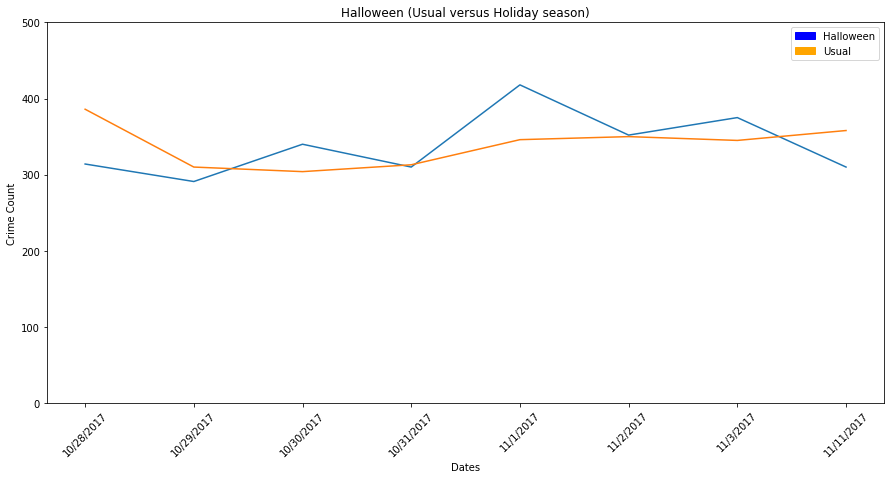

In [71]:
halloween_result = pd.DataFrame(columns=['Date', 'Crime Number'])
crime_list = []
date_list = []

find_crime_date ('10/28/2017', crime_list, date_list)
find_crime_date ('10/29/2017', crime_list, date_list)
find_crime_date ('10/30/2017', crime_list, date_list)
find_crime_date ('10/31/2017', crime_list, date_list)
find_crime_date ('11/1/2017', crime_list, date_list)
find_crime_date ('11/2/2017', crime_list, date_list)
find_crime_date ('11/3/2017', crime_list, date_list)
find_crime_date ('11/11/2017', crime_list, date_list)

se_c = pd.Series(crime_list)
se_d = pd.Series(date_list)
halloween_result['Crime Number'] = se_c
halloween_result['Date'] = se_d

week_b4_hal = pd.DataFrame(columns=['Date', 'Crime Number'])
crime_list = []
date_list = []

find_crime_date ('10/20/2017', crime_list, date_list)
find_crime_date ('10/21/2017', crime_list, date_list)
find_crime_date ('10/22/2017', crime_list, date_list)
find_crime_date ('10/23/2017', crime_list, date_list)
find_crime_date ('10/24/2017', crime_list, date_list)
find_crime_date ('10/25/2017', crime_list, date_list)
find_crime_date ('10/26/2017', crime_list, date_list)
find_crime_date ('10/27/2017', crime_list, date_list)

se_c = pd.Series(crime_list)
se_d = pd.Series(date_list)
week_b4_hal['Crime Number'] = se_c
week_b4_hal['Date'] = se_d

bf_hal = halloween_result['Crime Number']
af_hal = week_b4_hal['Crime Number']

plt.figure(1, figsize=(15, 7))
plt.xticks(range(len(halloween_result['Crime Number'])), halloween_result['Date'])
plt.xticks(rotation=45)
plt.plot(halloween_result['Crime Number'])
plt.plot(week_b4_hal['Crime Number'])

blue_patch = mpatches.Patch(color='blue', label='Halloween')
orange_patch = mpatches.Patch(color='orange', label='Usual')
plt.legend(handles=[blue_patch,orange_patch])

plt.title('Halloween (Usual versus Holiday season)')
plt.xlabel('Dates')
plt.ylabel('Crime Count')
plt.ylim(ymin=0)
plt.ylim(ymax=500)
plt.show()

We create another data frame with number of crimes for the time frame of a few days before Thanksgiving up to a couple of days after Thanksgiving. We then create a line graph and plot the dates along with the number of crimes.We find that there are several crimes right before Thanksgiving, peaking in our timeframe. Then, there is a a significant decrease at the day of Thanksgiving and the day after that crime rate goes back up.

We hypothesize that the crime rate going down on Thanksgiving may be due to the face that people are spending time with their loved ones, and stores are usaully all closed on Thanksgiving. We also hypothesize that crime going back up the day after Thanksgiving may be due to Black Friday, in which people tend to camp out near stores and argue over the biggest sales of the year. 

#### Thanksgiving

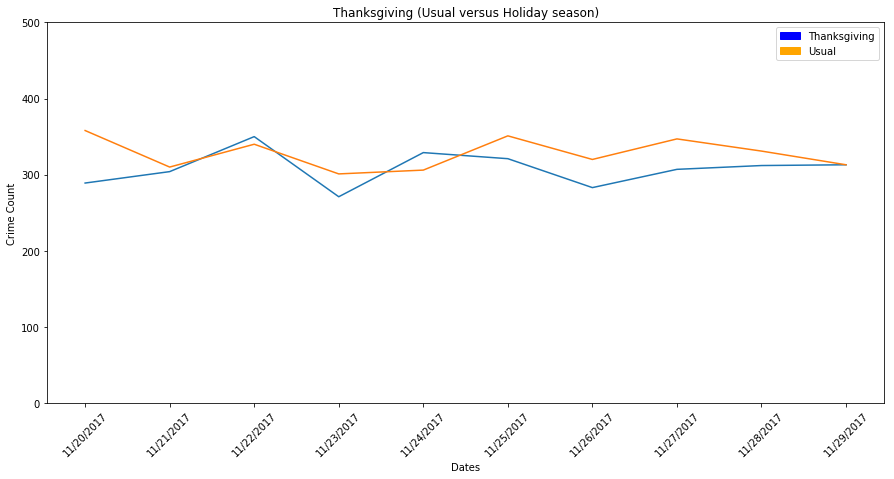

In [79]:
thanksgiving_result = pd.DataFrame(columns=['Date', 'Crime Number'])
crime_list = []
date_list = []

# holiday
find_crime_date ('11/20/2017', crime_list, date_list)
find_crime_date ('11/21/2017', crime_list, date_list)
find_crime_date ('11/22/2017', crime_list, date_list)
find_crime_date ('11/23/2017', crime_list, date_list)
find_crime_date ('11/24/2017', crime_list, date_list)
find_crime_date ('11/25/2017', crime_list, date_list)
find_crime_date ('11/26/2017', crime_list, date_list)
find_crime_date ('11/27/2017', crime_list, date_list)
find_crime_date ('11/28/2017', crime_list, date_list)
find_crime_date ('11/29/2017', crime_list, date_list)



se_c = pd.Series(crime_list)
se_d = pd.Series(date_list)
thanksgiving_result['Crime Number'] = se_c
thanksgiving_result['Date'] = se_d

weeks_b4_th = pd.DataFrame(columns=['Date', 'Crime Number'])
crime_list = []
date_list = []

find_crime_date ('11/10/2017', crime_list, date_list)
find_crime_date ('11/11/2017', crime_list, date_list)
find_crime_date ('11/12/2017', crime_list, date_list)
find_crime_date ('11/13/2017', crime_list, date_list)
find_crime_date ('11/14/2017', crime_list, date_list)
find_crime_date ('11/15/2017', crime_list, date_list)
find_crime_date ('11/16/2017', crime_list, date_list)
find_crime_date ('11/17/2017', crime_list, date_list)
find_crime_date ('11/18/2017', crime_list, date_list)
find_crime_date ('11/19/2017', crime_list, date_list)

se_c = pd.Series(crime_list)
se_d = pd.Series(date_list)
weeks_b4_th['Crime Number'] = se_c
weeks_b4_th['Date'] = se_d

bf_th = thanksgiving_result['Crime Number']
af_th = weeks_b4_th['Crime Number']

plt.figure(1, figsize=(15, 7))
plt.xticks(range(len(thanksgiving_result['Crime Number'])), thanksgiving_result['Date'])
plt.xticks(rotation=45)
plt.plot(thanksgiving_result['Crime Number'])
plt.plot(weeks_b4_th['Crime Number'])

blue_patch = mpatches.Patch(color='blue', label='Thanksgiving')
orange_patch = mpatches.Patch(color='orange', label='Usual')
plt.legend(handles=[blue_patch,orange_patch])

plt.title('Thanksgiving (Usual versus Holiday season)')
plt.xlabel('Dates')
plt.ylabel('Crime Count')
plt.ylim(ymin=0)
plt.ylim(ymax=500)
plt.show()

### Crimes by Type over Holidays (before, during, after)

#### Halloween

We create a bar graph showing crime rates on the day before the holiday, the day of the holiday, and the day after the holiday. This one in particular is for Halloween: we can see that there is very minor differences for assault, possession, and robbery in all three time frames. On Halloween itself, theft and burglary decrease significantly, and we can see that the day after, theft, narcotics, burglary, and alcohol increases by quite a bit.

Theft might be low since, as stated earlier, most people are spending times with their family or friends in parties. Burglary might be down since many people are at home giving out candy to children and there are usually lots of people walking the streets on Halloween night. The day after, people may be getting charges for the mistakes that they made on Halloween since there are more alcohol charges. As with New Years, people may be wanting to buy more drugs as they may have used it all on Halloween night, relaying to the increase in narcotics.

C:\Users\Vince-PC\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


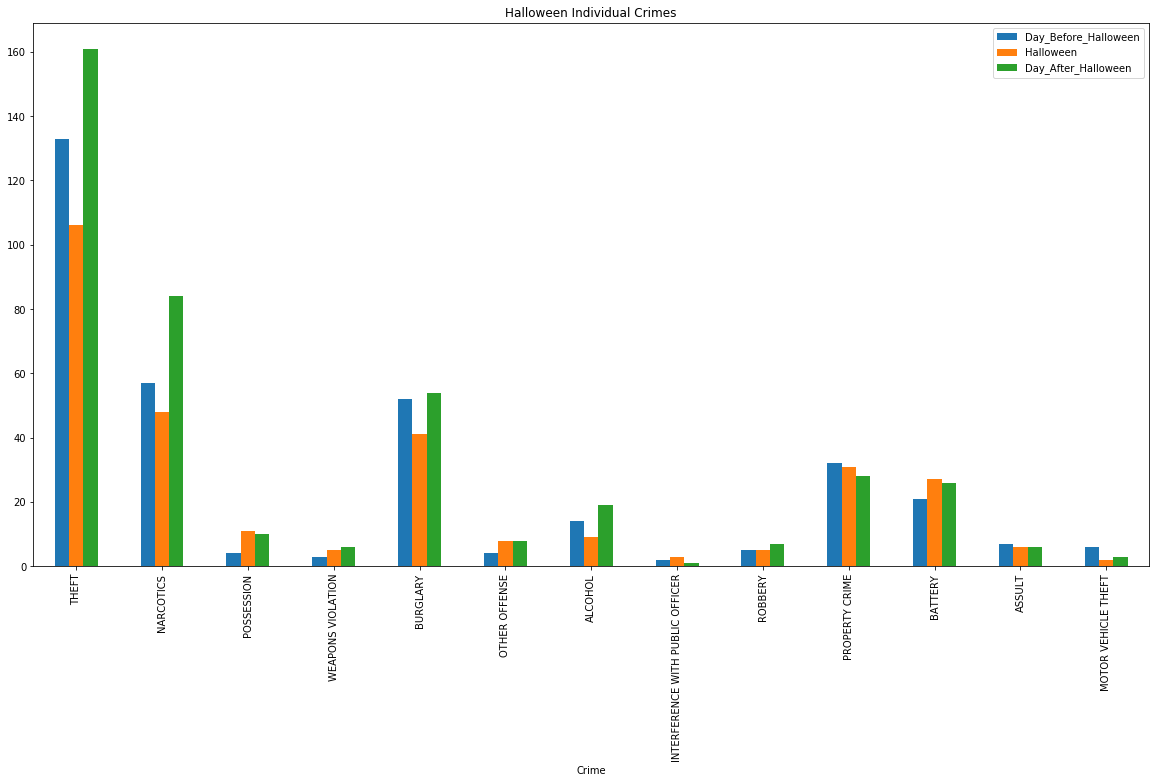

In [80]:
df = pd.DataFrame(columns=['Crime', 'Day_Before_Halloween', 'Halloween', 'Day_After_Halloween'])
df.Crime = original.crime.unique()
df.Day_Before_Halloween = original.crime.unique()
df.Halloween = original.crime.unique()
df.Day_After_Halloween = original.crime.unique()

lst = []
lst = date_finder('10/30/2017')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict1 = dict(zip(ls_k, ls_v))

lst = []
lst = date_finder('10/31/2017')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict2 = dict(zip(ls_k, ls_v))

lst = []
lst = date_finder('11/1/2017')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict3 = dict(zip(ls_k, ls_v))


df.Day_Before_Halloween = df.Day_Before_Halloween.map(new_dict1) 

df.Halloween = df.Halloween.map(new_dict2) 

df.Day_After_Halloween = df.Day_After_Halloween.map(new_dict3) 

df = df.dropna()

df.plot(title='Halloween Individual Crimes', x="Crime", y=["Day_Before_Halloween", "Halloween", "Day_After_Halloween"], kind="bar", figsize=(20, 10))





We create a bar graph showing crime rates on the day before the holiday, the day of the holiday, and the day after the holiday. This one in particular is for Christmas: we can see that there is very minor differences for possession, motor vehicle theft, assault, alcohol, property crime, and burglary in all three time frames. We can see that for theft and narcotics especially there is a major difference.

Theft might be low since, as stated earlier, most people are spending times with their loved ones and most stores are locked up and closed. We expected there to be a major difference for alcohol as many people drink on the holiday, but part of the reason why there is not might be since most people celebrate Christmas in their own private homes. 


#### Christmas

C:\Users\Vince-PC\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


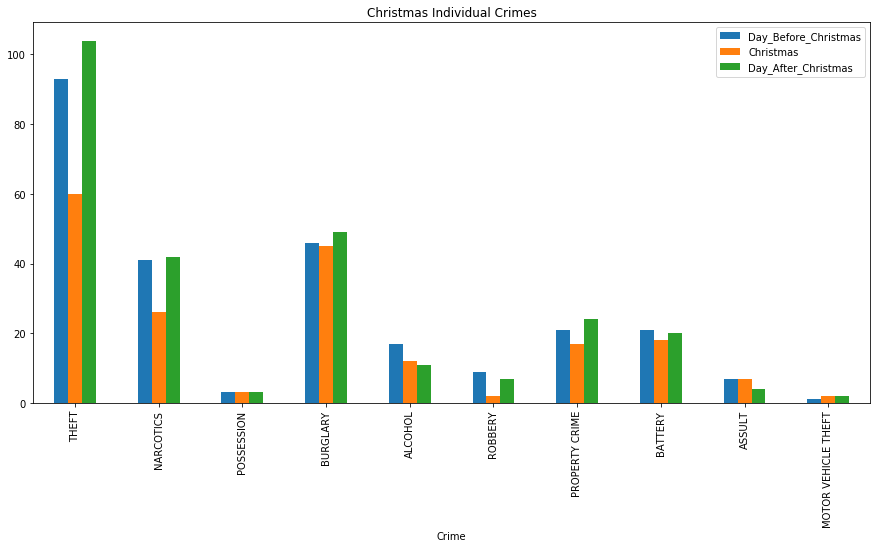

In [81]:
df = pd.DataFrame(columns=['Crime', 'Day_Before_Christmas', 'Christmas', 'Day_After_Christmas'])
df.Crime = original.crime.unique()
df.Day_Before_Christmas = original.crime.unique()
df.Christmas = original.crime.unique()
df.Day_After_Christmas = original.crime.unique()

lst = []
lst = date_finder('12/24/2017')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict1 = dict(zip(ls_k, ls_v))

lst = []
lst = date_finder('12/25/2017')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict2 = dict(zip(ls_k, ls_v))

lst = []
lst = date_finder('12/26/2017')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict3 = dict(zip(ls_k, ls_v))


df.Day_Before_Christmas = df.Day_Before_Christmas.map(new_dict1) 

df.Christmas = df.Christmas.map(new_dict2) 

df.Day_After_Christmas = df.Day_After_Christmas.map(new_dict3) 

df = df.dropna(0)

df.plot(title='Christmas Individual Crimes',x="Crime", y=["Day_Before_Christmas", "Christmas", "Day_After_Christmas"], kind="bar", figsize=(15, 7))



We create a bar graph showing crime rates on the day before the holiday, the day of the holiday, and the day after the holiday. This one in particular is for New Years Eve and New Years: we can see that there is very minor differences for many of the crimes in all three time frames. The major differences for New Years Eve include theft and narcotics decreasing, and for alcohol we see a significant increase. For New Years, the major differences include theft and narcotics increasing, and alcohol and battery increase even more than they did on New Years Eve.

Theft might be lower on New Years Eve because stores lock up and close early that night, and people are usually waiting to countdown for the New Year. We expected alcohol to increase significantly on New Years Eve due to the amount of partying and drinking that typically occurs for holidays such as New Years.

Theft and narcotics may increase on New Years due to less celebration; stores typically open at normal times and are open until normal hours. Distribution of drugs (narcotics) may be higher since maybe people have used all their drugs the day before to celebrate New Years Eve. People may be charged with alcohol on New Years after the countdown, and battery may inrerase due to more drunken actions. 

#### New Years

C:\Users\Vince-PC\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


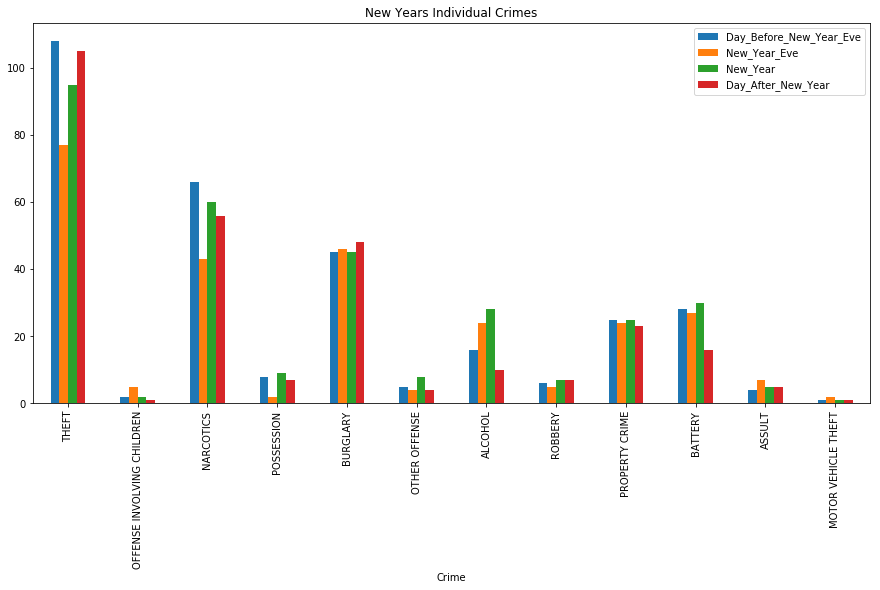

In [82]:
df = pd.DataFrame(columns=['Crime', 'Day_Before_New_Year_Eve', 'New_Year_Eve', 'New_Year', 'Day_After_New_Year'])
df.Crime = original.crime.unique()
df.Day_Before_New_Year_Eve = original.crime.unique()
df.New_Year_Eve = original.crime.unique()
df.New_Year = original.crime.unique()
df.Day_After_New_Year = original.crime.unique()

lst = []
lst = date_finder('12/30/2017')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict1 = dict(zip(ls_k, ls_v))

lst = []
lst = date_finder('12/31/2017')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict2 = dict(zip(ls_k, ls_v))

lst = []
lst = date_finder('1/1/2018')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict3 = dict(zip(ls_k, ls_v))

lst = []
lst = date_finder('1/2/2018')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict4 = dict(zip(ls_k, ls_v))



df.Day_Before_New_Year_Eve = df.Day_Before_New_Year_Eve.map(new_dict1) 

df.New_Year_Eve = df.New_Year_Eve.map(new_dict2) 

df.New_Year = df.New_Year.map(new_dict3) 

df.Day_After_New_Year = df.Day_After_New_Year.map(new_dict4) 

df = df.dropna()

df.plot(title='New Years Individual Crimes',x="Crime", y=["Day_Before_New_Year_Eve", "New_Year_Eve", "New_Year", "Day_After_New_Year"], kind="bar", figsize=(15, 7))




We create a bar graph showing crime rates on the day before the holiday, the day of the holiday, and the day after the holiday. This one in particular is for Thanksgiving: we can see that there is very minor differences for all time frames for motor veehicle theft, other offenses, and assault. On Thanksgiving, there is a huge drop in theft. On Black Friday, the day after Thanksgiving, there is a huge increase in theft as compared to Thanksgiving. We can also see that theft pretty much goes back to its steady rate after the Thanksgiving weekend. 

Theft might be low since, as stated earlier, most people are spending times with their loved ones and most stores are locked up and closed on Thanksgiving. We expected there to be a major difference for alcohol as many people drink on the holiday, but part of the reason why there is not might be since most people celebrate Thanksgiving in their own private homes. 

Note: For Thanksgiving bar graph, The 'Day_After_Thanksgiving' is referring to day after end of the entire Thanksgiving weekend, not just the November 23rd.

#### Thanksgiving

C:\Users\Vince-PC\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


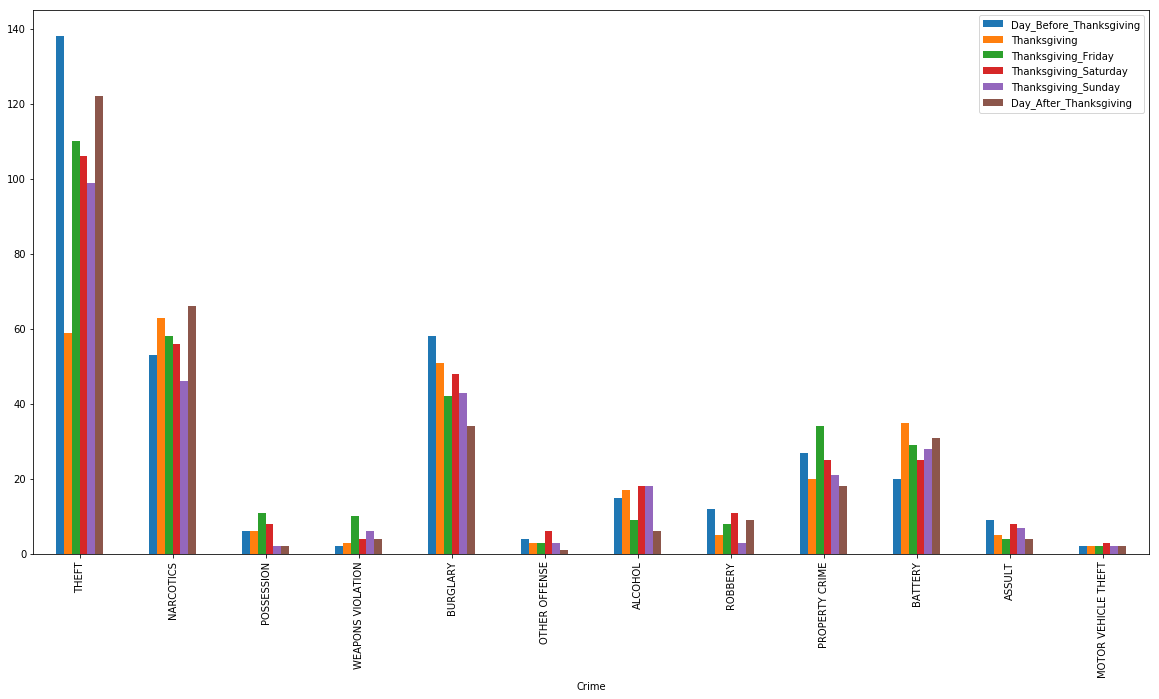

In [83]:
df = pd.DataFrame(columns=['Crime', 'Day_Before_Thanksgiving', 'Thanksgiving', 'Thanksgiving_Friday', 'Thanksgiving_Saturday', 'Thanksgiving_Sunday', 'Day_After_Thanksgiving'])
df.Crime = original.crime.unique()
df.Day_Before_Thanksgiving = original.crime.unique()
df.Thanksgiving = original.crime.unique()
df.Thanksgiving_Friday = original.crime.unique()
df.Thanksgiving_Saturday = original.crime.unique()
df.Thanksgiving_Sunday = original.crime.unique()
df.Day_After_Thanksgiving = original.crime.unique()

lst = []
lst = date_finder('11/22/2017')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict1 = dict(zip(ls_k, ls_v))


lst = []
lst = date_finder('11/23/2017')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict2 = dict(zip(ls_k, ls_v))


lst = []
lst = date_finder('11/24/2017')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict3 = dict(zip(ls_k, ls_v))


lst = []
lst = date_finder('11/25/2017')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict4 = dict(zip(ls_k, ls_v))


lst = []
lst = date_finder('11/26/2017')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict5 = dict(zip(ls_k, ls_v))


lst = []
lst = date_finder('11/27/2017')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict6 = dict(zip(ls_k, ls_v))



df.Day_Before_Thanksgiving = df.Day_Before_Thanksgiving.map(new_dict1) 

df.Thanksgiving = df.Thanksgiving.map(new_dict2) 

df.Thanksgiving_Friday = df.Thanksgiving_Friday.map(new_dict3) 

df.Thanksgiving_Saturday = df.Thanksgiving_Saturday.map(new_dict4) 

df.Thanksgiving_Sunday = df.Thanksgiving_Sunday.map(new_dict5) 

df.Day_After_Thanksgiving = df.Day_After_Thanksgiving.map(new_dict6) 

df = df.dropna()

df.plot(x="Crime", y=["Day_Before_Thanksgiving", "Thanksgiving", "Thanksgiving_Friday", "Thanksgiving_Saturday", "Thanksgiving_Sunday", "Day_After_Thanksgiving"], kind="bar", figsize=(20, 10))







We create a bar graph showing crime rates of all holidays that we analyzed and compared them together. We can see that on Christmas crime rates are the lowest for all crimes in our graph (except theft, but very close to Thanksgiving). On Thanksgiving we can see that theft was at its lowest but narcotics, burglary, and battery is at its highest as compared to other crimes. 

Christmas is a major holiday that affects people all around the country, typically all families in the USA celebrate it and that might be the reason why people are "nicer" on this day. Thanksgiving may have high battery rates as people may get into fights with their families. New Years Eve and New Years have the highest alcohol charges due to huge celebrations and parties all over the city. 

#### Individual Crime Comparisons 

C:\Users\Vince-PC\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


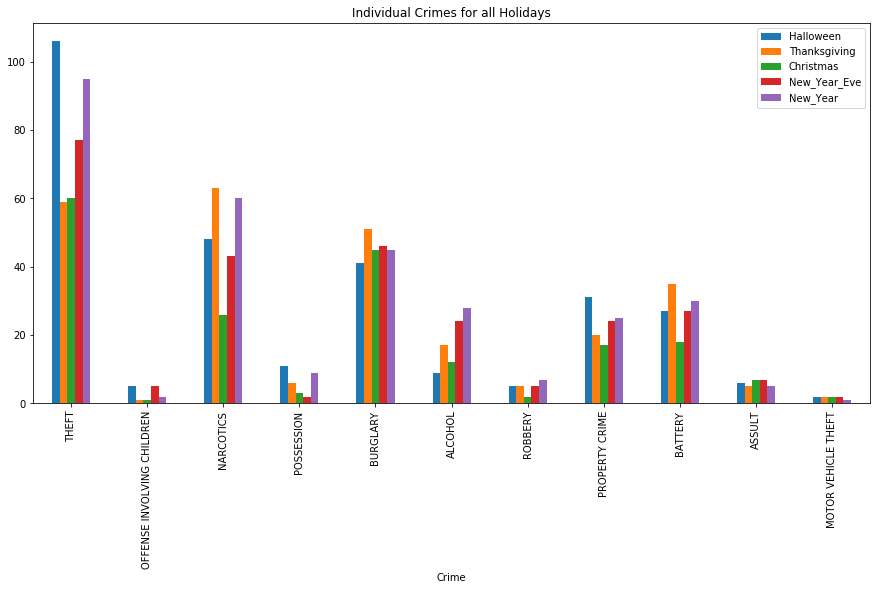

In [84]:
#Crime difference in each holiday

df = pd.DataFrame(columns=['Crime', 'Halloween', 'Thanksgiving', 'Christmas', 'New_Year_Eve', 'New_Year'])
df.Crime = original.crime.unique()
df.Halloween = original.crime.unique()
df.Thanksgiving = original.crime.unique()
df.Christmas = original.crime.unique()
df.New_Year_Eve = original.crime.unique()
df.New_Year = original.crime.unique()


lst = []
lst = date_finder('10/31/2017')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict1 = dict(zip(ls_k, ls_v))

lst = []
lst = date_finder('11/23/2017')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict2 = dict(zip(ls_k, ls_v))

lst = []
lst = date_finder('12/25/2017')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict3 = dict(zip(ls_k, ls_v))

lst = []
lst = date_finder('12/31/2017')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict4 = dict(zip(ls_k, ls_v))

lst = []
lst = date_finder('1/1/2018')

ls_k = Counter(lst).keys()
ls_v = Counter(lst).values()

new_dict5 = dict(zip(ls_k, ls_v))


df.Halloween = df.Halloween.map(new_dict1) 

df.Thanksgiving = df.Thanksgiving.map(new_dict2) 

df.Christmas = df.Christmas.map(new_dict3) 

df.New_Year_Eve = df.New_Year_Eve.map(new_dict4) 

df.New_Year = df.New_Year.map(new_dict5) 

df = df.dropna()

df.plot(title='Individual Crimes for all Holidays',x="Crime", y=["Halloween", "Thanksgiving", "Christmas", "New_Year_Eve", "New_Year"], kind="bar", figsize=(15, 7))



### Statistical Analysis

Using a t-test ('t_test' function) to compare the crime distribution (usual versus holiday)

Compare the crime distribution (usual versus holiday). Since Christmas and New Years were only a few days apart, we looked at them together. We used an alpha level of 0.05. Our hypotheses is as follows: 

Null Hypothesis: There is no significant difference between crime rate on a usual week and crime rate on a holiday.

Alternate Hypothesis: There is a significant difference between crime rate on a usual week and crime rate on a holiday. 
 


#### Halloween

In [85]:
t_val, p_val = t_test(bf_hal, af_hal)

There is NOT a significant difference!


#### Thanksgiving

In [86]:
t_val, p_val = t_test(bf_th, af_th)

There is NOT a significant difference!


#### Christmas and New Years

In [87]:
t_val, p_val = t_test(bf_ch_ny, af_ch_ny)

T-Test accomplished, there is a significant difference between usual crime and over holiday!


### Regression Analysis

Based on our t-test analysis, we take a further look at Christmas and New Years. Not enough significance was discovered Halloween and Thanksgiving to warrant deeper analysis. As shown below there is an extreme outlier, with number of crimes in San Diego County hitting only around 200. We graphed the days leading up to Christmas and New Year's (12-6-17 to 1-4-18). This outlier refers to Christmas and we can spot that throughout this period of time, crime is steadily decreasing if we follow the line of best fit. We can also see that on New Year's Eve there is a dramatic decrease of crimes, and then as New Years follows, the crime rate goes back up. As a result, we can see that in this holiday period, people tend to commit less crimes (or less crimes are being caught and we need to dispatch more officers in this time). 

It is highly likely that people really are committing less crimes on Christmas, because of the huge difference on this day compared with the usual days.

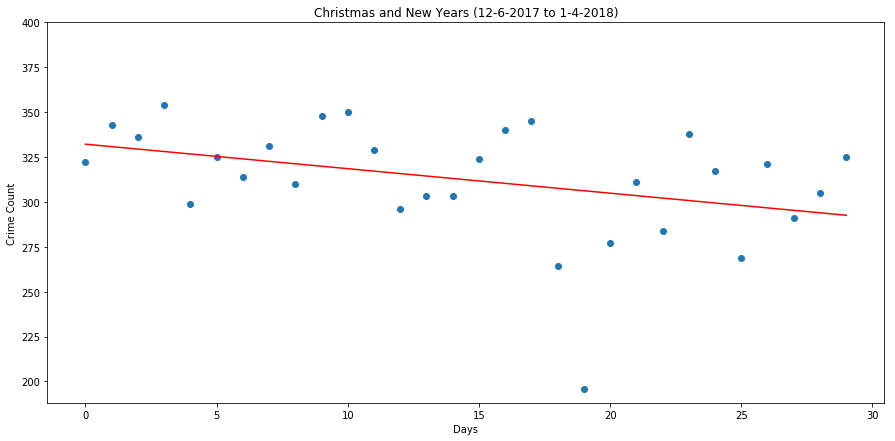

In [88]:
# Predictor variables (the Y variable)
temp = weeks_b4_ch_ny['Crime Number'].tolist() + ch_ny_result['Crime Number'].tolist()
lst = [] # the Y variable
total = 0
for i in temp:
    total = total + i
    lst.append(total)
Y = temp

# Response variables (the X variable)
X = list(range(0,len(lst)))

X_1=sm.add_constant(X)
model = sm.OLS(Y,X_1)
results = model.fit()
Y_predicted=results.predict(X_1)
plt.figure(1, figsize=(15, 7))
plt.scatter(X,Y)
plt.ylim(ymax=400)
plt.xlabel("Days")
plt.ylabel("Crime Count")
plt.title("Christmas and New Years (12-6-2017 to 1-4-2018)")
plt.plot(X,Y_predicted, "r")
plt.show()

# Ethics and Privacy

   We have permission to use the data since it is public and is available on the sandag.org site. The location of the crime that occurred is listed but any information about the individual is not revealed. 

   There should be no potential biases in our dataset since this data is off of SANDAG, the San Diego Association of Governments. This information should be purely 'fact' and not be opinionated at all. There is a certain jargon used to describe crimes and our data uses it. Our data should not be very problematic. Even though our research about crime may not be representative of the San Diego population, we want to see the crimes that occur in San Diego to help us determine if there needs to be changes to police officer dispatches on a certain timeframe. We were unable to gather any information about officer dispatchments (police departments never replied to us) but we can try and predict whether or not we should try to catch more people. 

   There should not be any issue with privacy as the only information listed is about the crime, and not about the individual who commited the crime. Safety Harbour does not say that we should remove any information regarding the address of the crime as it does not give the address of the individual, unless the crime occurred in the culprit’s house. However, the data does not directly list out who that individual is, only the crime that was committed and there are many storefronts whose addresses are listed for a crime (maybe theft), meaning that a culprit who commits a crime in a residence could possibly be anyone (burglary), not just the resident.

# Conclusion and Results

Overall, we found different results between the different holidays. For Halloween(p=0.99) and Thanksgiving(p=0.06), p>0.05 so there was no significant difference found between crime rates on a usual week and crime rates found in that timeframe. We ended up failing to reject our null hypothesis and we are 95% sure that there is no significant difference. For Christmas and New Years(p=0.04), we found that p>0.05 so there is a significant difference found between crime rates on a usual week and crime rates found in that timeframe.

We did not support our original hypothesis that crime rate will go up on these holidays, which is a little surprising since we originally thought that since inebriation would be high during all these holidays. We also thought that theft would be incredibly high during these times since people were starting the festivities of gift giving, but in the end most of these crimes did not follow this pattern.

Our data that we were provided with is not representative of all crimes that occurred in San Diego as there are criminals who are never caught and charged with anything. Some crimes found on a certain date are also unable to posted in official data because some cases require court hearings before the suspect can be charged with that certain crime. We predict that there might need to be more officers dispatched on Halloween as we expected more crimes to occur on that holiday. Not many crimes were committed on Halloween as compared to the day before and after that, and Halloween is a holiday in which children are easily vulnerable to commit crimes upon.

Some possible further investigation could revolve around mixing our data visualization and analysis. This would be done to create a heat map of the types of crime done based on their location. Although, the geolocation of crimes did not provide any imediate explanation as to the significane of the data we found, it is possible that a mixture of the two could provide us with new enlightening information as to why these significant differences are occuring.
